In [68]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
import itertools

import wandb

## Load models

In [91]:
# Initialize a run
run = wandb.init(project="wandb-trash-classification")

# Access and download model. Returns path to downloaded artifact
model_no_aug_path = run.use_model(name="run-l9czqvo2-trash-classification-no-aug.keras:latest")
model_aug_path = run.use_model(name="run-8tr9l1t0-trash-classification-aug.keras:latest")

wandb.finish()

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


### Assign weights to each model

In [92]:
model_base = load_model(model_no_aug_path)
model_base.load_weights('./models/trash-classification-no-aug.weights.h5')

model_aug = load_model(model_aug_path)
model_aug.load_weights('./models/trash-classification-aug.weights.h5')

In [93]:
image_dir = os.path.expanduser('dataset-resized')

## Functions to do the analysis

In [94]:
def generate_data(is_aug=False):
    if is_aug == True:
        # With data augmentation
        datagen = ImageDataGenerator(
            rescale=1./255, 
            validation_split=0.2,
            width_shift_range=0.1, 
            height_shift_range=0.1, 
            horizontal_flip=True
        )
    else:  
        # Without data augmentation (except rescaling)
        datagen = ImageDataGenerator(
            rescale=1./255, 
            validation_split=0.2
        )
    
    
    train_generator = datagen.flow_from_directory(
        image_dir,
        target_size=(28, 28),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
    
    validation_generator = datagen.flow_from_directory(
        image_dir,
        target_size=(28, 28),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, validation_generator

In [95]:
def plot_confusion_matrix(model, validation_generator):
    # Get true labels and predictions
    validation_generator.reset()
    Y_pred = model.predict(validation_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = validation_generator.classes
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=validation_generator.class_indices.keys(), columns=validation_generator.class_indices.keys())

    # Normalize confusion matrix to get per-class accuracies
    class_counts = np.sum(cm, axis=1)
    class_accuracies = np.diagonal(cm) / class_counts
    
    # Get class names
    target_names = list(validation_generator.class_indices.keys())

    # Show classification metrics
    print('Classification Report')
    target_names = list(validation_generator.class_indices.keys())
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot per-class accuracies
    plt.figure(figsize=(10, 6))
    sns.barplot(x=target_names, y=class_accuracies)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Per-Class Accuracy')
    plt.show()

## Classification result analysis

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


C:\Users\adven\anaconda3\envs\trash-classification\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 476ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step
Classification Report
              precision    recall  f1-score   support

   cardboard       0.25      0.09      0.13        80
       glass       0.19      0.15      0.17       100
       metal       0.09      0.04      0.05        82
       paper       0.25      0.32      0.28       118
     plastic       0.17      0.29      0.21        96
       trash       0.07      0.11      0.09        27

    accuracy                           0.19       503
   macro

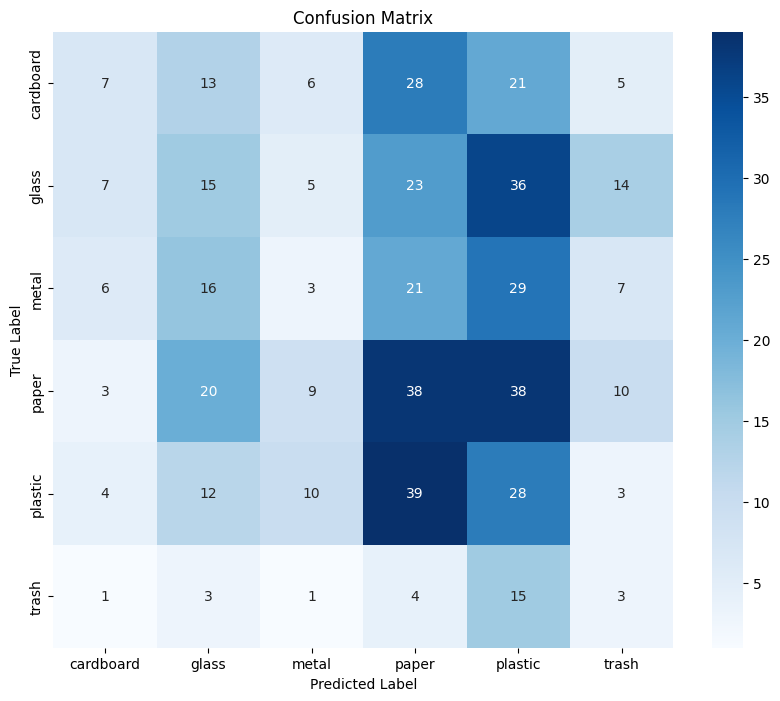

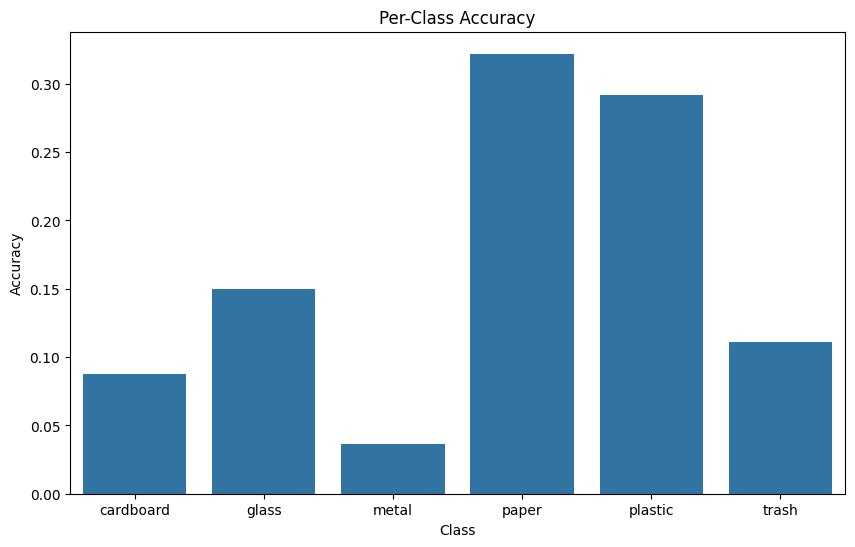

In [96]:
_, validation_generator = generate_data(is_aug=False)
plot_confusion_matrix(model_base, validation_generator)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


C:\Users\adven\anaconda3\envs\trash-classification\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 422ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/st ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step
Classification Report
              precision    recall  f1-score   support

   cardboard       0.15      0.10      0.12        80
       glass       0.16      0.10      0.12       100
       metal       0.14      0.09      0.11        82
       paper       0.20      0.40      0.27       118
     plastic       0.20      0.18      0.19        96
       trash       0.08      0.04      0.05        27

    accuracy                

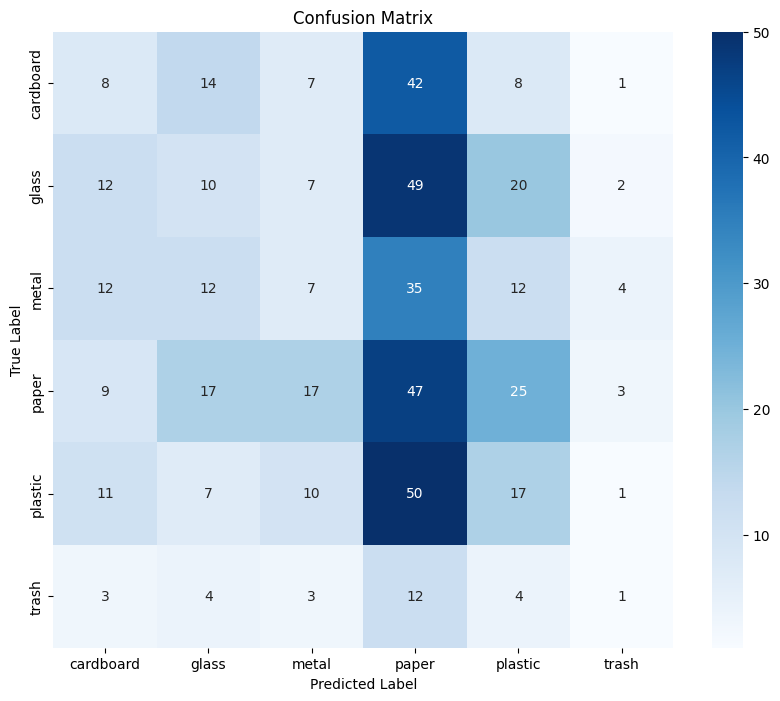

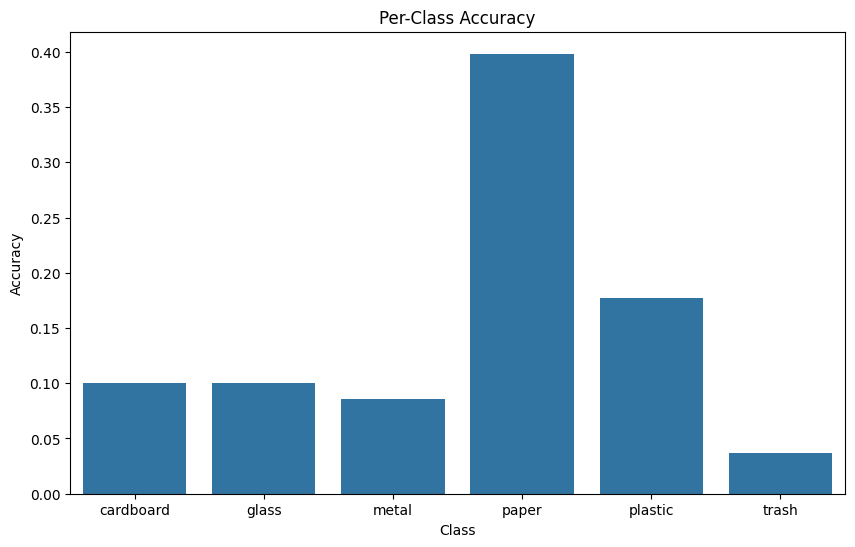

In [97]:
_, validation_generator_aug = generate_data(is_aug=True)
plot_confusion_matrix(model_aug, validation_generator_aug)

Comparing the prediction result from both models, we can see that the model trained with more least data augmentation methods slightly have better performance, although the accuracy in some classes are lower than the augmented model. This is a normal behaviour since we used the small epoch and inpute image size. If we do the training with proper hyperparameters and input size, the model with data augmentation will more likely to have better performance.

The hardest images to classify are categorized in `trash` which contains various types of waste materials with damaged and irregular shape. Moreover, we only have a very small training size of the class `trash` compared to the other classes, making such results quite expected. To overcome the limitation in the model performance, we can try several works in the future:
- Increase the number of epoch
- Decrease learning rate
- Adjust the CNN construction
- **Add more training data (most important)**

### Visualizing wrong and correct predictions in the `trash` category

In [108]:
# Reset the validation generator to ensure it starts from the beginning
validation_generator_aug.reset()

# Predict the classes for the validation data
Y_pred = model_aug.predict(validation_generator_aug)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true classes
y_true = validation_generator_aug.classes

# Get the class indices
class_indices = validation_generator_aug.class_indices
class_names = list(class_indices.keys())

# Find the index of the 'trash' class
trash_class_index = class_indices['trash']

# Identify misclassified indices for the 'trash' class
misclassified_indices = np.where((y_true == trash_class_index) & (y_pred != trash_class_index))[0]

# Identify correctly classified indices for the 'trash' class
classified_indices = np.where((y_true == trash_class_index) & (y_pred == trash_class_index))[0]

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/st ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step


In [109]:
misclassified_indices

array([476, 477, 478, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502],
      dtype=int64)

In [110]:
classified_indices

array([479], dtype=int64)

**Missclassified**

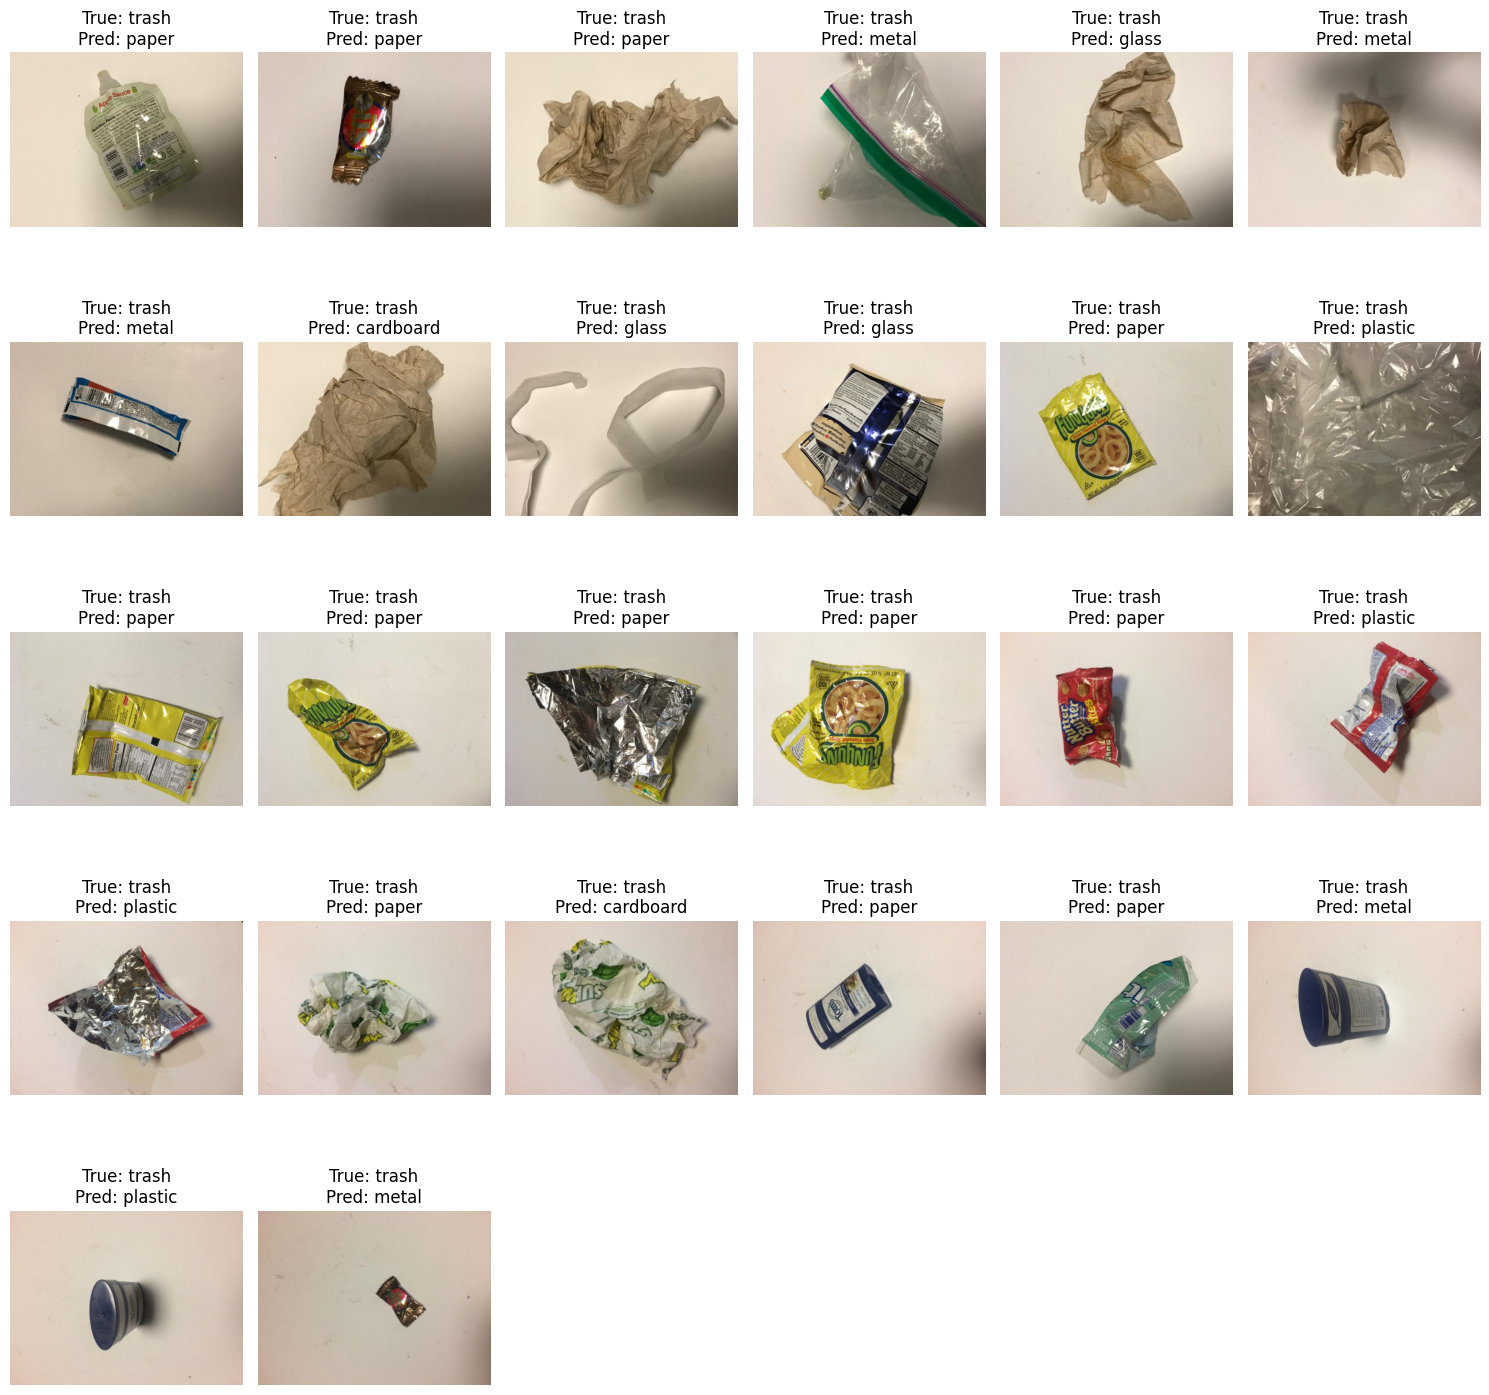

In [112]:
plt.figure(figsize=(15, 15))

# Iterate through the misclassified indices
for i, idx in enumerate(misclassified_indices):
    # Get the corresponding image and its true and predicted labels
    img_path = validation_generator_aug.filepaths[idx]
    img = plt.imread(img_path)
    true_label = 'trash'
    pred_label = class_names[y_pred[idx]]

    # Plot the image
    plt.subplot(5, 6, i + 1)
    plt.imshow(img)
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

**Classified**

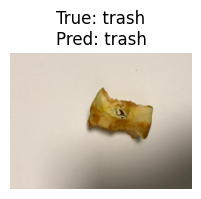

In [113]:
plt.figure(figsize=(10, 10))

# Iterate through the misclassified indices
for i, idx in enumerate(classified_indices):
    # Get the corresponding image and its true and predicted labels
    img_path = validation_generator_aug.filepaths[idx]
    img = plt.imread(img_path)
    true_label = 'trash'
    pred_label = class_names[y_pred[idx]]

    # Plot the image
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

As we can see in the plot above, the model with data augmentation can only correctly predict 1 trash images. The image looks like an apple. It makes sense the model can only classify this image because this image looks very different compared to the other images in the `trash` category, which is not made of cardboard, glass, metal, paper, or plastic.